In [1]:
import sys
sys.path.append("../../")
from multiprocessing import Pool
import tqdm
import pickle
from pathlib import Path
from contextlib import closing
from rdkit import Chem
import numpy as np
import pandas as pd

# Load fragmentation results

In [2]:
%%time
fragments_path = Path("/net/cci/cschlick/Filtered_COD3/fragmentation_results.pkl")
with fragments_path.open("rb") as fh:
  fragmentation_results = pickle.load(fh)

CPU times: user 23.1 s, sys: 3.4 s, total: 26.5 s
Wall time: 26.6 s


In [3]:
fragmentation_results_dict = {}
for result in fragmentation_results:
  fragmentation_results_dict[result["filepath"].stem]=result

## Featurize fragments

In [4]:
from phenixml.featurizers.ani_featurizer import ANIFeaturizer

In [5]:
# elements and parameters
covalent_organic = ["O","C","H","N","P","S","Cl","B","F","I","Br"]
metals = ["Na","K","Ca","Fe","Mn","Zn","Mg","Cu","Co"]

params = {'radial_cutoff': 4.6,
 'radial_nu': 32,
 'radial_probes': [0.7,
                  1.4,
                  1.9,
                  2.4,
                  3.2,
                  3.8,
                  4.4],
 'angular_cutoff': 3.1,
 'angular_nu': 4,
 'angular_probes': [0.0, 1.57, 3.14, 4.71],
 'angular_radial_probes': [0.7,1.4,1.9,2.4],
 'angular_zeta': 8,
 'min_probed_value': 0.0,
 'exclude_hydrogens': False,
 'elements_considered': covalent_organic}

In [6]:
mode = "bond"
if mode == "angle":
  fragment_key = "angle_fragments"
elif mode == "bond":
  fragment_key = "bond_fragments"

def worker(cod_id):
  frags = fragmentation_results_dict[cod_id][fragment_key]
  featurizer = ANIFeaturizer.from_bond_angle_frags(frags,params)
  
  if featurizer is None:
    return (cod_id,None)
  else:
    return (cod_id,featurizer.featurize())



In [7]:
work = fragmentation_results_dict.keys()
with closing(Pool(processes=32)) as pool:
  results = []
  for result in tqdm.tqdm(pool.imap_unordered(worker, work), total=len(work)):
      results.append(result)
  pool.terminate()

100%|██████████| 63018/63018 [03:22<00:00, 311.75it/s]


In [8]:
X = []
y = []
frags = []

for cod_id,features in results:
  if features is not None:
    frgs = fragmentation_results_dict[cod_id][fragment_key]
    frags+=frgs
    X.append(features)
    if mode == 'bond':
      y+=[frag.properties["bond_length"] for frag in frgs]
    elif mode == "angle":
      y+=[frag.properties["angle_deg"] for frag in frgs]

In [9]:
X = np.vstack(X)
y = np.array(y)
assert(X.shape[0]==len(y))

In [10]:
from sklearn.ensemble import RandomForestRegressor


In [11]:
from sklearn.model_selection import train_test_split
space = np.arange(X.shape[0])
train, test = train_test_split(space,test_size=0.2)
frags_train, frags_test = [frags[i] for i in train], [frags[i] for i in test]

  
X_train, X_test = X[train],X[test]
y_train, y_test = y[train],y[test]

In [12]:
import joblib
import os

In [ ]:
import umap

In [14]:
%%time
min_samples_leaf_grid = [10,20,40,80]
models = []
for msl in min_samples_leaf_grid:
  model = RandomForestRegressor(n_estimators=100,min_samples_leaf=msl, random_state=0,n_jobs=-1)
  models.append(model)
for model in models:
  model.fit(X_train,y_train)

CPU times: user 4d 12h 54min 50s, sys: 1h 47min 38s, total: 4d 14h 42min 29s
Wall time: 1h 32min 22s


In [15]:
sizes = []
for i,model in enumerate(models):

  writepath = "/dev/shm/cschlick/models/rfmodel_ani_"+mode+"_msl"+str(min_samples_leaf_grid[i])+".joblib"
  joblib.dump(model, writepath, compress=3)  
  size_mb = np.round(os.path.getsize(writepath) / 1024 / 1024, 2)
  sizes.append(size_mb)

In [16]:
print(sizes)

[258.38, 133.4, 69.48, 36.39]


In [17]:
model = models[0]

In [18]:
%%time
y_pred = model.predict(X_test)

CPU times: user 38.4 s, sys: 1.16 s, total: 39.5 s
Wall time: 4.27 s


Text(0, 0.5, 'Predicted')

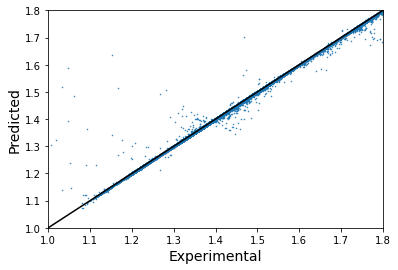

In [19]:
df = pd.DataFrame({"dists":y_test.flatten(),"pred":y_pred.flatten()})
ax = df.plot.scatter("dists","pred",s=0.25)
if mode == "bond":
  ax.set_xlim(1,1.8)
  ax.set_ylim(1,1.8)
elif mode == "angle":
  ax.set_xlim(50,140)
  ax.set_ylim(50,140)
ax.plot([0,200],[0,200],color="black")
ax.set_xlabel("Experimental",fontsize=14)
ax.set_ylabel("Predicted",fontsize=14)

In [ ]:
from sklearn.metrics import mean_squared_error
import seaborn as sns
residuals = y_test-y_pred
sns.histplot(residuals)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE:",rmse)

## Predict some single molecules